In [1]:
import sys
# sys.path.append(r'C:\Users\edwar\Documents\LabStuff\ibllib\brainbox\io')
#sys.path.append(r'C:\Users\IBL\Documents\ibl_analysis\ONE\one')
import matplotlib.pyplot as plt
import numpy as np
from brainbox.io.one import load_wheel_reaction_times
import brainbox.behavior.wheel as wh
from ibllib.io.raw_data_loaders import *
from ibllib.pipes.tasks import *
from ibllib.pipes import *
from ibllib.io.extractors.bpod_trials import *
from one.api import ONE
from one.alf.io import *
from ibllib.io.extractors.base import BaseBpodTrialsExtractor, run_extractor_classes
from ibllib.io.extractors.camera import CameraTimestampsBpod
from ibllib.io.extractors.ephys_fpga import extract_wheel_moves
from ibllib.io.extractors.training_wheel import extract_first_movement_times
#from localAlf import load_wheel_reaction_times_local
from brainbox.behavior.training import *
import scipy.io.wavfile as wavfile
from scipy import signal
from ScanImageTiffReader import ScanImageTiffReader
import json
import ast
import math
from murphlib.tools import *

In [2]:
session_path = r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\J_L2\20241118\behavior'

trials, wheel, output_files = extract_all(session_path, save=True)

In [3]:
trials['table']

,intervals_0,intervals_1,ruleCue_times,ruleCueTrigger_times,response_times,choice,stimOnTrigger_times,stimOn_times,contrastLeft,contrastRight,feedback_times,feedbackType,rewardVolume,probabilityLeft,firstMovement_times,modality,omission
0,0.000000,7.975401,5.103300,5.083200,6.431800,1,5.905000,6.109600,0.5,NaN,6.431900,1,1.0,0.50,6.359106,0,0
1,9.314799,12.442902,9.754899,9.723899,10.898899,1,10.523899,10.576299,1.0,NaN,10.898999,1,1.0,0.50,10.804106,0,0
2,13.821900,25.442102,19.491100,19.461500,21.899900,1,21.569200,21.625400,NaN,1.0,21.900000,-1,0.0,0.50,NaN,0,0
3,26.780300,32.008701,29.418400,29.387000,30.460300,1,30.187000,30.226300,1.0,NaN,30.460400,1,1.0,0.85,29.747106,0,1
4,33.258899,38.642901,34.245999,34.212899,35.091599,1,35.012899,35.059599,NaN,1.0,35.091699,-1,0.0,0.50,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,2064.770199,2071.556901,2065.322299,2065.290699,2068.016699,-1,2066.090699,2066.140199,1.0,NaN,2068.016799,-1,0.0,0.65,NaN,0,0
301,2072.816200,2085.840201,2073.286300,2073.253600,2084.282500,-1,2074.053600,2074.091000,NaN,1.0,2084.282600,1,1.0,0.70,2084.142106,0,0
302,2087.144000,2097.191001,2087.671100,2087.640400,2093.635900,-1,2088.440400,2088.491000,0.5,NaN,2093.636000,-1,0.0,0.50,NaN,0,0
303,2098.380199,2136.906901,2099.050499,2099.017899,2133.359399,-1,2099.817899,2099.890199,0.5,NaN,2133.359499,-1,0.0,0.80,NaN,0,0


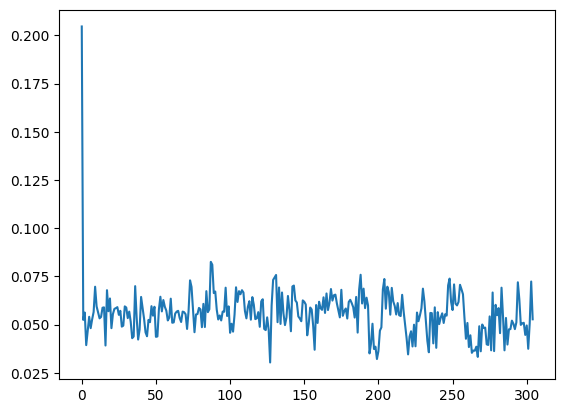

In [4]:
plt.plot(np.array(trials['table']['stimOn_times'])-np.array(trials['table']['stimOnTrigger_times']))

In [5]:
trials['table']['stimOn_times'] = np.where(trials['table']['stimOn_times'] < trials['table']['stimOnTrigger_times'],trials['table']['stimOnTrigger_times']+0.06,trials['table']['stimOn_times'])
# trials['table']['vis_stimOn_times'] = np.where(trials['table']['modality']==0,trials['table']['stimOnTrigger_times'],np.nan)
# trials['table']['vis_stimOn_times'] = trials['table']['vis_stimOn_times']+0.06
trials['table']['vis_stimOn_times'] = np.where(trials['table']['modality']==0,trials['table']['stimOn_times'],np.nan)


trials['table']['aud_stimOn_times'] = np.where(trials['table']['modality']==1,trials['table']['stimOnTrigger_times'],np.nan)
trials['table']['aud_stimOn_times'] = trials['table']['aud_stimOn_times']+np.median(trials['table']['ruleCue_times']-trials['table']['ruleCueTrigger_times'])
trials['table'].loc[trials['table']['feedbackType']==-1,'feedback_times'] = trials['table'].loc[trials['table']['feedbackType']==-1,'feedback_times']+np.median(trials['table']['ruleCue_times']-trials['table']['ruleCueTrigger_times'])
trials['table']

,intervals_0,intervals_1,ruleCue_times,ruleCueTrigger_times,response_times,choice,stimOnTrigger_times,stimOn_times,contrastLeft,contrastRight,feedback_times,feedbackType,rewardVolume,probabilityLeft,firstMovement_times,modality,omission,vis_stimOn_times,aud_stimOn_times
0,0.000000,7.975401,5.103300,5.083200,6.431800,1,5.905000,6.109600,0.5,NaN,6.431900,1,1.0,0.50,6.359106,0,0,6.109600,NaN
1,9.314799,12.442902,9.754899,9.723899,10.898899,1,10.523899,10.576299,1.0,NaN,10.898999,1,1.0,0.50,10.804106,0,0,10.576299,NaN
2,13.821900,25.442102,19.491100,19.461500,21.899900,1,21.569200,21.625400,NaN,1.0,21.932200,-1,0.0,0.50,NaN,0,0,21.625400,NaN
3,26.780300,32.008701,29.418400,29.387000,30.460300,1,30.187000,30.226300,1.0,NaN,30.460400,1,1.0,0.85,29.747106,0,1,30.226300,NaN
4,33.258899,38.642901,34.245999,34.212899,35.091599,1,35.012899,35.059599,NaN,1.0,35.123899,-1,0.0,0.50,NaN,0,0,35.059599,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,2064.770199,2071.556901,2065.322299,2065.290699,2068.016699,-1,2066.090699,2066.140199,1.0,NaN,2068.048999,-1,0.0,0.65,NaN,0,0,2066.140199,NaN
301,2072.816200,2085.840201,2073.286300,2073.253600,2084.282500,-1,2074.053600,2074.091000,NaN,1.0,2084.282600,1,1.0,0.70,2084.142106,0,0,2074.091000,NaN
302,2087.144000,2097.191001,2087.671100,2087.640400,2093.635900,-1,2088.440400,2088.491000,0.5,NaN,2093.668200,-1,0.0,0.50,NaN,0,0,2088.491000,NaN
303,2098.380199,2136.906901,2099.050499,2099.017899,2133.359399,-1,2099.817899,2099.890199,0.5,NaN,2133.391699,-1,0.0,0.80,NaN,0,0,2099.890199,NaN


In [23]:
frames_metadata_export_folder = r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_L2\20241018\arm2'
frames_metadata_export_path = os.path.join(frames_metadata_export_folder, 'ca_img_frames_metadata.json')
img_path = find_tif_file(frames_metadata_export_folder)
try:
    with open(frames_metadata_export_path, 'r') as json_file:
        frames_metadata = json.load(json_file)
except:
    
    reader=ScanImageTiffReader(img_path)
    frames_metadata = []

    with ScanImageTiffReader(img_path) as reader:
        num_frames = reader.shape()[0]  # Assuming the first dimension represents frames
        
        for i in range(num_frames):
            description = reader.description(i)
            frame_metadata = {}  # Dictionary to hold this frame's metadata
            
            for line in description.split('\n'):
                if '=' in line:  # Ensure there's a key-value pair to parse
                    key, value = line.split('=', 1)  # Split by the first '='
                    key = key.strip()
                    
                    try:
                        # Safely evaluate the value string to the appropriate Python data type
                        # This works for numbers, lists, dictionaries, etc.
                        value = ast.literal_eval(value.strip())
                    except (ValueError, SyntaxError):
                        # If evaluation fails, keep the value as a string
                        value = value.strip()
                    
                    frame_metadata[key] = value
            
            frames_metadata.append(frame_metadata)
        
    with open(frames_metadata_export_path, 'w') as json_file:
        json.dump(frames_metadata, json_file)


In [24]:
auxTrigger = []
frame_time = []
trigger_frame_num = []
# Iterate through each frame's metadata
if 'arm1' in img_path:
    trig_chan = 'auxTrigger0'
elif 'arm2' in img_path:
    trig_chan = 'auxTrigger1'
for frame_metadata in frames_metadata:
    frame_time.append(frame_metadata['frameTimestamps_sec'])
    # Check if 'auxTrigger0' exists and is not empty
    if trig_chan in frame_metadata and frame_metadata[trig_chan]:
        # Extend the all_auxTrigger0 list with the numbers from this frame's auxTrigger0
        if not auxTrigger:
            pass
        elif frame_metadata['frameNumbers'] in trigger_frame_num or frame_metadata['frameNumbers'] < max(trigger_frame_num)+5:
            continue
        print(frame_metadata)
        if type(frame_metadata[trig_chan]) == list:
            first_float = frame_metadata[trig_chan][0]
        elif type(frame_metadata[trig_chan]) == str:
            match = re.search(r'\d+\.\d+', frame_metadata['auxTrigger1'])
            if match:
                first_float = float(match.group())
            else:
                print(f"Missing trigger for framenum {frame_metadata['frameNumbers']}")
        else:
            print(f"cannot parse trigger for framenum {frame_metadata['frameNumbers']}")
        auxTrigger.append(first_float)
        trigger_frame_num.append(frame_metadata['frameNumbers'])
auxTrigger = np.array(auxTrigger)
len(auxTrigger)

{'frameNumbers': 204, 'acquisitionNumbers': 1, 'frameNumberAcquisition': 204, 'frameTimestamps_sec': 13.36101193, 'acqTriggerTimestamps_sec': -1.0, 'nextFileMarkerTimestamps_sec': -1.0, 'endOfAcquisition': 0, 'endOfAcquisitionMode': 0, 'dcOverVoltage': 0, 'epoch': '[2024 10 18 14 59 30.426]', 'auxTrigger0': [], 'auxTrigger1': [13.412835655, 13.41354539, 13.413548425, 13.41355164, 13.413552635, 13.41355382, 13.4135549, 13.413555905, 13.413556945, 13.413557985, 13.413559125, 13.413560165, 13.413561205, 13.413562295, 13.41356343, 13.41356451, 13.4135656, 13.41356674, 13.41356778, 13.41356887, 13.41356996, 13.41541047, 13.41619102, 13.41619315, 13.416201915, 13.41620291, 13.416204, 13.416205135, 13.416206175, 13.41620702, 13.416208305, 13.416209485, 13.41621096, 13.4162118, 13.41621285, 13.41621361, 13.416214415, 13.41621522, 13.41621621, 13.4162172, 13.41621839, 13.418134445, 13.418830795, 13.41884475, 13.41884693, 13.41884901, 13.41885015, 13.41885114, 13.418852145, 13.41885327, 13.41885

229

In [25]:
len(trials['table'])

226

In [26]:
ruleCue_times = np.array(trials['table']['ruleCue_times'])

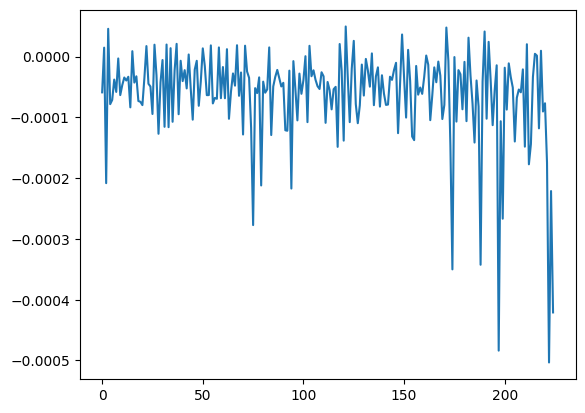

In [28]:
realTriggers = auxTrigger[3:]
plt.plot(np.diff(ruleCue_times)-np.diff(realTriggers[:len(ruleCue_times)]))
assert(all(np.diff(ruleCue_times)-np.diff(realTriggers[:len(ruleCue_times)]) < 0.001))

In [25]:
np.where(np.diff(ruleCue_times)-np.diff(realTriggers[:len(ruleCue_times)]) > 0.001)[0]

array([], dtype=int64)

In [29]:
auxTrigger=auxTrigger[3:]


In [30]:
auxTrigger = auxTrigger[:len(ruleCue_times)]

In [31]:
print(f'first go cue in image: {auxTrigger[0]}')
print(f"first go cue in statemachine table: {trials['table']['ruleCue_times'][0]}")

first go cue in image: 27.93930335
first go cue in statemachine table: 4.190199999999997


In [32]:

statemachine_offset = auxTrigger[0]-trials['table']['ruleCue_times'][0] # time in s that state machine is leading the first goCueTime


In [18]:
def find_closest_index(value, list_of_values):
    # Find the index of the closest value in list_of_values
    return np.abs(np.array(list_of_values) - value).argmin()


In [33]:

table_for_img = trials['table'].copy()
for col in table_for_img.columns:
    if 'times' in col or 'intervals' in col:
        table_for_img[col] = table_for_img[col].add(statemachine_offset)
        table_for_img[col] = table_for_img[col].apply(lambda x: find_closest_index(x, frame_time))
        table_for_img[col] = table_for_img[col].apply(lambda x: np.nan if x == 0 else x)

In [34]:
table_for_img

,intervals_0,intervals_1,ruleCue_times,ruleCueTrigger_times,response_times,choice,stimOnTrigger_times,stimOn_times,contrastLeft,contrastRight,feedback_times,feedbackType,rewardVolume,probabilityLeft,firstMovement_times,modality,omission,vis_stimOn_times,aud_stimOn_times
0,361,541,424,424,517,1,436,439,1.0,NaN,517,1,3.0,0.50,511.0,0,NaN,439.0,NaN
1,562,633,569,568,609,1,581,581,1.0,NaN,609,1,3.0,0.50,589.0,0,NaN,581.0,NaN
2,652,917,659,658,863,1,671,671,NaN,1.0,863,-1,0.0,0.50,NaN,0,NaN,671.0,NaN
3,939,1017,971,970,993,1,983,984,1.0,NaN,993,1,3.0,0.85,991.0,0,NaN,984.0,NaN
4,1036,1104,1057,1057,1081,1,1069,1070,0.5,NaN,1081,1,3.0,0.50,1072.0,0,NaN,1070.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,27330,27804,27346,27345,27780,-1,27357,27358,NaN,0.5,27780,1,3.0,0.50,NaN,0,NaN,27358.0,NaN
222,27828,28813,27835,27835,28759,0,27847,27848,NaN,1.0,28760,-1,0.0,0.50,NaN,0,NaN,27848.0,NaN
223,28834,29196,28842,28842,29172,-1,28854,28855,NaN,1.0,29172,1,3.0,0.65,29168.0,0,NaN,28855.0,NaN
224,29216,30133,29234,29234,30110,-1,29246,29247,NaN,1.0,30110,1,3.0,0.50,30107.0,0,NaN,29247.0,NaN


In [35]:
#valid_trials=np.arange(0,314)
valid_trials = np.arange(0,len(table_for_img))
table_for_img = table_for_img.iloc[valid_trials]
table_for_img

,intervals_0,intervals_1,ruleCue_times,ruleCueTrigger_times,response_times,choice,stimOnTrigger_times,stimOn_times,contrastLeft,contrastRight,feedback_times,feedbackType,rewardVolume,probabilityLeft,firstMovement_times,modality,omission,vis_stimOn_times,aud_stimOn_times
0,361,541,424,424,517,1,436,439,1.0,NaN,517,1,3.0,0.50,511.0,0,NaN,439.0,NaN
1,562,633,569,568,609,1,581,581,1.0,NaN,609,1,3.0,0.50,589.0,0,NaN,581.0,NaN
2,652,917,659,658,863,1,671,671,NaN,1.0,863,-1,0.0,0.50,NaN,0,NaN,671.0,NaN
3,939,1017,971,970,993,1,983,984,1.0,NaN,993,1,3.0,0.85,991.0,0,NaN,984.0,NaN
4,1036,1104,1057,1057,1081,1,1069,1070,0.5,NaN,1081,1,3.0,0.50,1072.0,0,NaN,1070.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,27330,27804,27346,27345,27780,-1,27357,27358,NaN,0.5,27780,1,3.0,0.50,NaN,0,NaN,27358.0,NaN
222,27828,28813,27835,27835,28759,0,27847,27848,NaN,1.0,28760,-1,0.0,0.50,NaN,0,NaN,27848.0,NaN
223,28834,29196,28842,28842,29172,-1,28854,28855,NaN,1.0,29172,1,3.0,0.65,29168.0,0,NaN,28855.0,NaN
224,29216,30133,29234,29234,30110,-1,29246,29247,NaN,1.0,30110,1,3.0,0.50,30107.0,0,NaN,29247.0,NaN


In [36]:
#table_for_img = table_for_img.loc[valid_trials]

table_for_img.to_csv(frames_metadata_export_folder+'\\table_for_img.csv', index=False)

AUDIO

In [37]:
audio_filepath = os.path.join(session_path, 'raw_behavior_data', '_iblrig_micData.raw.wav')
sample_rate, audio_data = wavfile.read(audio_filepath)

In [60]:
sample_rate

200000

In [49]:
frequencies, times, Sxx = signal.spectrogram(audio_data, fs=sample_rate, nperseg=1024, noverlap=512)

# Limit the frequencies to 20k Hz (20000 Hz)
max_frequency = 20000
freq_limit = frequencies <= max_frequency

# Apply the frequency limit to the data
frequencies = frequencies[freq_limit]
Sxx = Sxx[freq_limit, :]



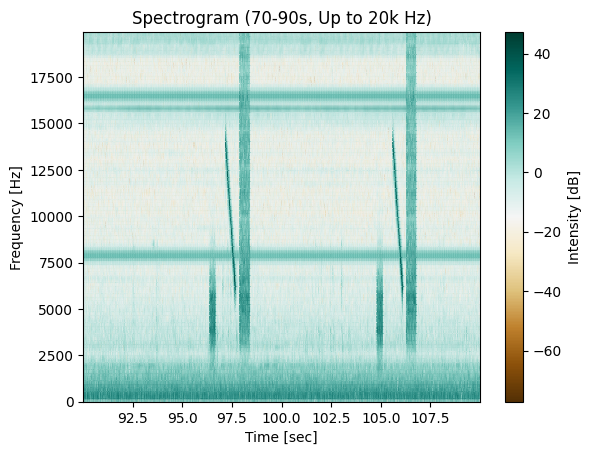

In [50]:
# Limit the time to the desired range (e.g., 70 to 90 seconds)
start_time = 90  # Start time in seconds
end_time = 110    # End time in seconds
time_limit = (times >= start_time) & (times <= end_time)

# Apply the time limit to the data
times = times[time_limit]
Sxx = Sxx[:, time_limit]

# Plot the spectrogram with the 'parula' colormap
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap='BrBG')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram (70-90s, Up to 20k Hz)')
plt.colorbar(label='Intensity [dB]')
plt.show()

In [39]:
frequencies, times, Sxx = signal.spectrogram(audio_data, fs=sample_rate, nperseg=1024, noverlap=512)

# Convert the spectrogram to decibels for better visualization and peak detection
Sxx_dB = 10 * np.log10(Sxx)

In [83]:


# Define your frequency bins (in Hz)
frequency_bins = [
    (5000, 8000),   # 5kHz to 8kHz
]

# Initialize list to store the averaged intensities and detected peaks
averaged_intensities = []
peaks_in_bins = []

# Loop through each frequency bin
for freq_range in frequency_bins:
    # Create a mask to select the frequencies within the current bin
    freq_mask = (frequencies >= freq_range[0]) & (frequencies <= freq_range[1])

    # Average the intensity across the selected frequency range (frequency axis)
    avg_intensity = np.mean(Sxx_dB[freq_mask, :], axis=0)
    
    # Find peaks in the averaged intensity across time
    peaks, properties = signal.find_peaks(avg_intensity, height=20)  # Adjust 'height' as needed

    # Store the results
    averaged_intensities.append(avg_intensity)
    peaks_in_bins.append(peaks)

# Set a time difference threshold (in seconds)
time_threshold = 0.2

# Find consecutive peaks that are ~0.2s apart
consecutive_peaks_times = []

for peaks, freq_range in zip(peaks_in_bins, frequency_bins):
    # Calculate the time difference between consecutive peaks
    time_diffs = np.diff(times[peaks])
    
    # Find pairs of peaks where the time difference is close to 0.2 seconds
    consecutive_pairs = np.where((time_diffs >= time_threshold - 0.05) & (time_diffs <= time_threshold + 0.05))[0]
    
    # For each pair, store the time of the first peak
    for pair_idx in consecutive_pairs:
        first_peak_time = times[peaks[pair_idx]]
        consecutive_peaks_times.append(first_peak_time)

# Output the times of occurrence of the first peak in each pair
print("Times of first peaks in consecutive pairs ~0.2s apart:")
print(consecutive_peaks_times)
print(len(consecutive_peaks_times))

Times of first peaks in consecutive pairs ~0.2s apart:
[2.1248, 14.49216, 23.9744, 29.46048, 34.432, 48.57088, 55.19104, 60.2624, 75.89376, 88.26112, 101.4528, 106.9312, 113.64096, 113.8304, 122.74176, 151.70048, 156.98688, 175.0528, 185.00352, 196.39296, 213.2608, 218.07104, 224.40448, 242.2016, 252.096, 266.4448, 275.6736, 283.85792, 321.99168, 329.6256, 334.53312, 351.24224, 376.36096, 393.33632, 400.1792, 410.87232, 421.5424, 466.55232, 481.46176, 533.19424, 543.19104, 548.46464, 567.12704, 577.73824, 602.63168, 602.81856, 612.32128, 612.52096, 627.8144, 633.51552, 643.84, 666.45504, 686.30272, 691.65312, 711.2064, 753.59232, 766.54848, 773.72672, 780.03456, 804.57728, 815.1936, 833.2288, 833.43104, 847.10912, 864.61184, 875.0464, 889.39008, 896.4352, 906.18112, 961.45152, 975.99232, 994.97216, 1021.0688, 1027.77088, 1034.48832, 1056.31744, 1065.67424, 1072.29696, 1081.48992, 1086.65344, 1092.65408, 1117.63456, 1127.92064, 1187.72992, 1196.91264, 1217.01888, 1222.47936, 1250.18624,

In [70]:
# Step 1: Define the frequency range of interest (for example, 2kHz to 3kHz)
min_frequency = 5000
max_frequency = 15000

# Step 2: Filter the frequencies to include only the desired range
freq_mask = (frequencies >= min_frequency) & (frequencies <= max_frequency)

# Step 3: Average the intensity over the selected frequency range
avg_intensity_in_range = np.mean(Sxx_dB[freq_mask, :], axis=0)

# Step 4: Find peaks in the averaged intensity across time
peaks, properties = signal.find_peaks(avg_intensity_in_range, height=10)  # Adjust 'height' as needed

# Step 5: Identify periods where peaks are exactly 0.1s apart
peak_times = times[peaks]
time_diffs = np.diff(peak_times)

# Set threshold to find periods of exactly 0.1 seconds
exact_duration = 0.1
exact_peak_pairs = []

# Look for pairs of peaks where the difference is exactly 0.1 seconds
for i, time_diff in enumerate(time_diffs):
    if abs(time_diff - exact_duration) <= 0.01:  # Allowing a small tolerance (0.01s)
        exact_peak_pairs.append((peak_times[i], peak_times[i + 1]))

# Output periods with peaks exactly 0.1 seconds apart
print("Periods with peaks exactly 0.1 seconds apart:")
for pair in exact_peak_pairs:
    print(f"From {pair[0]:.2f}s to {pair[1]:.2f}s")

Periods with peaks exactly 0.1 seconds apart:


First peak in 12-15kHz range (within 10s) occurs at 0.72 seconds


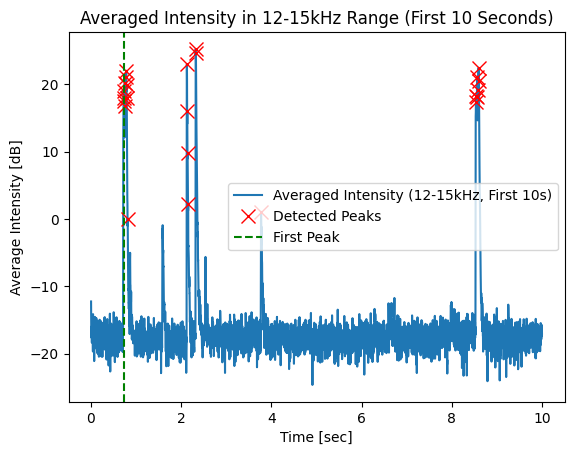

In [86]:
min_frequency = 12000
max_frequency = 15000

# Step 2: Filter the frequencies to include only the 12-15kHz range
freq_mask = (frequencies >= min_frequency) & (frequencies <= max_frequency)

# Step 3: Average the intensity over the selected frequency range (12-15kHz)
avg_intensity_12_15khz = np.mean(Sxx_dB[freq_mask, :], axis=0)

# Step 4: Limit to the first 10 seconds
time_limit = 10
time_mask = times <= time_limit

# Apply the time mask to the times and intensity
times_10sec = times[time_mask]
avg_intensity_12_15khz_10sec = avg_intensity_12_15khz[time_mask]

# Step 5: Find peaks in the averaged intensity for the first 10 seconds
peaks, properties = signal.find_peaks(avg_intensity_12_15khz_10sec, height=0)  # Adjust 'height' threshold as needed

# Step 6: Find the time of the first peak (if any peaks were found)
if len(peaks) > 0:
    first_peak_time = times_10sec[peaks[0]]  # Time of the first peak
    print(f"First peak in 12-15kHz range (within 10s) occurs at {first_peak_time:.2f} seconds")
else:
    print("No peaks found in the 12-15kHz range within the first 10 seconds")

# Plot only the first 10 seconds of averaged intensity and highlight the first peak
plt.plot(times_10sec, avg_intensity_12_15khz_10sec, label="Averaged Intensity (12-15kHz, First 10s)")
plt.plot(times_10sec[peaks], avg_intensity_12_15khz_10sec[peaks], 'rx', markersize=10, label="Detected Peaks")
if len(peaks) > 0:
    plt.axvline(x=first_peak_time, color='g', linestyle='--', label='First Peak')

plt.title('Averaged Intensity in 12-15kHz Range (First 10 Seconds)')
plt.xlabel('Time [sec]')
plt.ylabel('Average Intensity [dB]')
plt.legend()
plt.show()

In [73]:
np.sum(trials['table']['feedbackType']==1)

172

In [51]:
assert(len(consecutive_peaks_times)==np.sum(trials['table']['feedbackType']==1))

In [17]:
trials['table']

,intervals_0,intervals_1,ruleCue_times,ruleCueTrigger_times,response_times,choice,stimOnTrigger_times,stimOn_times,contrastLeft,contrastRight,feedback_times,feedbackType,rewardVolume,probabilityLeft,firstMovement_times,modality,vis_stimOn_times,aud_stimOn_times
0,0.000000,10.892903,4.389800,4.370600,9.345900,-1,5.170600,5.378000,NaN,0.5,9.346000,1,3.0,0.50,9.201982,0,5.3780,NaN
1,12.624400,15.826302,13.310900,13.276400,14.273200,-1,14.076400,14.127900,NaN,0.5,14.273300,1,3.0,0.50,13.949982,0,14.1279,NaN
2,17.044500,31.642802,25.219400,25.187400,28.098800,1,27.654700,27.694500,NaN,1.0,25.267300,-1,0.0,0.50,NaN,0,27.6945,NaN
3,33.085800,39.576202,34.886600,34.855200,36.029100,1,35.655200,35.694300,NaN,1.0,34.933600,-1,0.0,0.95,NaN,0,35.6943,NaN
4,40.948300,47.792802,42.181500,42.145300,46.248200,1,45.600700,45.644600,1.0,NaN,46.248300,1,3.0,0.90,45.940982,0,45.6446,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,2505.229199,2537.323101,2507.970799,2507.938699,2535.788699,-1,2508.738699,2508.791299,NaN,0.0,2535.788799,1,3.0,0.35,NaN,1,NaN,2508.823799
315,2538.696899,2545.474701,2539.224699,2539.187799,2541.920499,-1,2539.987799,2540.041399,0.0,NaN,2539.273199,-1,0.0,0.50,NaN,1,NaN,2540.073899
316,2546.701699,2567.373001,2547.415699,2547.381199,2565.817299,-1,2548.181199,2548.239699,NaN,0.0,2565.817399,1,3.0,0.45,2565.562982,1,NaN,2548.272199
317,2568.664099,2574.573001,2571.364699,2571.331699,2573.023599,1,2572.131699,2572.191399,0.0,NaN,2573.023699,1,3.0,0.50,2572.911982,1,NaN,2572.223899


In [74]:
print(np.diff(trials['table'].loc[trials['table']['feedbackType']==1, 'feedback_times'])[:])
print(np.diff(consecutive_peaks_times)[:])

[12.3664    9.4736    5.4984    4.9595   14.1515    6.6096    5.0711
 15.6323   12.3686   13.1934    5.478     6.7115    9.1009   28.9608
  5.2983   18.0551    9.9527   11.3894   16.8686    4.8229    6.3334
 17.7869    9.8952    8.4031    5.9479    9.2281    8.1967   25.9522
 12.1732    7.6344    4.9081   16.7195   25.1227   16.977     6.841
 10.6839   10.672    45.0127    4.9752    9.9355   51.7477    9.9978
  5.2631   18.6628   10.6118   24.8953    9.6907   15.5037    5.6924
 10.3343   22.6134   19.8547    5.3505   19.5435   42.4004   12.9451
  7.1855    6.3135   24.5427   10.6077   18.2504   13.6771   17.5038
 10.4267   14.345     7.0448    9.7582   55.2624   14.5431   18.9811
 26.1095    6.7025    6.7059   21.8316    9.3667    6.6143    9.1935
  5.1631    6.0022   24.9815   10.2872   15.7454    9.3954   27.6565
  7.0161    9.193    20.1075    5.4629   27.6979    5.9945   45.6715
  4.9796    5.7148   27.352    18.3784   23.9802    6.2423   14.7392
 50.5802    7.1893    6.214     5.5

In [80]:
rewardTrigger_times = np.array(trials['table'].loc[trials['table']['feedbackType']==1, 'feedback_times'])
rewardValveSound_times = consecutive_peaks_times

In [87]:
first_peak_time

0.72448

In [88]:
corrected_rewardValveSound_times = rewardValveSound_times + trials['table']['ruleCue_times'][0]-first_peak_time

corrected_rewardValveSound_times

array([   6.24782,   18.61518,   28.09742,   33.5835 ,   38.55502,
         52.6939 ,   59.31406,   64.38542,   80.01678,   92.38414,
        105.57582,  111.05422,  117.76398,  117.95342,  126.86478,
        155.8235 ,  161.1099 ,  179.17582,  189.12654,  200.51598,
        217.38382,  222.19406,  228.5275 ,  246.32462,  256.21902,
        270.56782,  279.79662,  287.98094,  326.1147 ,  333.74862,
        338.65614,  355.36526,  380.48398,  397.45934,  404.30222,
        414.99534,  425.66542,  470.67534,  485.58478,  537.31726,
        547.31406,  552.58766,  571.25006,  581.86126,  606.7547 ,
        606.94158,  616.4443 ,  616.64398,  631.93742,  637.63854,
        647.96302,  670.57806,  690.42574,  695.77614,  715.32942,
        757.71534,  770.6715 ,  777.84974,  784.15758,  808.7003 ,
        819.31662,  837.35182,  837.55406,  851.23214,  868.73486,
        879.16942,  893.5131 ,  900.55822,  910.30414,  965.57454,
        980.11534,  999.09518, 1025.19182, 1031.8939 , 1038.61

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 46, 47, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 144, 145, 146, 148, 149, 150, 151, 152, 153, 154, 155, 156, 156, 158, 159, 160, 161, 163, 164, 165, 166, 167, 168, 169, 170, 171]


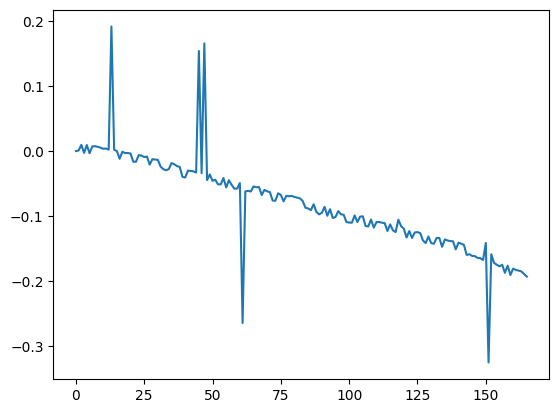

In [90]:
found_rewardValve_ind = [find_closest_index(corrected_rewardValveSound_times[i], rewardTrigger_times) for i in range(len(corrected_rewardValveSound_times))]
print(found_rewardValve_ind)
plt.plot(corrected_rewardValveSound_times-rewardTrigger_times[found_rewardValve_ind])

In [56]:
print(corrected_rewardValveSound_times[160:])
print(rewardTrigger_times[found_rewardValve_ind][160:])

[2418.42698 2423.75946 2439.20138 2444.73354 2470.84042 2495.17066
 2501.16874 2506.19146 2512.22538 2517.13546 2522.84426 2528.6273
 2534.42058 2565.64746]
[2418.602499 2423.9411   2439.384999 2444.9172   2471.016899 2495.348999
 2501.3544   2506.3786   2512.413699 2517.3245   2523.033099 2528.815599
 2534.610699 2565.839399]


In [6]:
cam_session_path = session_path
#cam_session_path = r'Z:\TM_Lab\Edward\Data\iblrig_data\Subjects\AG_R3\2023-11-14\001'
cam_frame_data = load_camera_frameData(cam_session_path, camera = 'left')
cam_frame_count, cam_gpio =  load_embedded_frame_data(cam_session_path, label='left', raw=False)
embed_frame_counter = np.asarray(cam_frame_data['embeddedFrameCounter'])
embed_ts = np.asarray(cam_frame_data['embeddedTimeStamp'])
camera_ts = np.asarray(cam_frame_data['Timestamp'])
bpod_trials = rawio.load_data(cam_session_path, task_collection='raw_behavior_data')

In [7]:
cam_frame_data

,Timestamp,embeddedTimeStamp,embeddedFrameCounter,embeddedGPIOPinState
0,0.000000,0.000000,0,"[False, True, False, True]"
1,0.035187,0.033125,2,"[False, True, False, True]"
2,0.038131,0.049625,3,"[False, True, False, True]"
3,0.054528,0.066250,4,"[False, True, False, True]"
4,0.070963,0.082750,5,"[False, True, False, True]"
...,...,...,...,...
154336,2556.082074,2555.805875,154337,"[False, True, False, True]"
154337,2556.099213,2555.822375,154338,"[False, True, False, True]"
154338,2556.115738,2555.839000,154339,"[False, True, False, True]"
154339,2556.131968,2555.855500,154340,"[False, True, False, True]"


In [ ]:
base = [CameraTimestampsBpod]

settings = rawio.load_settings(cam_session_path, task_collection='raw_behavior_data')
# out, fil = run_extractor_classes(base, save=False, session_path=cam_session_path, bpod_trials=bpod_trials, settings=settings,
#                                      task_collection='raw_behavior_data')

In [7]:
cam_start_bpod_time = bpod_trials[0]['behavior_data']['Events timestamps']['Port1In'][0]-bpod_trials[0]['behavior_data']['Trial start timestamp']
cam_start_bpod_time

4.486599999999999

In [8]:
trials['table']

,intervals_0,intervals_1,ruleCue_times,ruleCueTrigger_times,response_times,choice,stimOnTrigger_times,stimOn_times,contrastLeft,contrastRight,feedback_times,feedbackType,rewardVolume,probabilityLeft,firstMovement_times,modality,omission,vis_stimOn_times,aud_stimOn_times
0,0.000000,7.975401,5.103300,5.083200,6.431800,1,5.905000,6.109600,0.5,NaN,6.431900,1,1.0,0.50,6.359106,0,0,6.109600,NaN
1,9.314799,12.442902,9.754899,9.723899,10.898899,1,10.523899,10.576299,1.0,NaN,10.898999,1,1.0,0.50,10.804106,0,0,10.576299,NaN
2,13.821900,25.442102,19.491100,19.461500,21.899900,1,21.569200,21.625400,NaN,1.0,21.932200,-1,0.0,0.50,NaN,0,0,21.625400,NaN
3,26.780300,32.008701,29.418400,29.387000,30.460300,1,30.187000,30.226300,1.0,NaN,30.460400,1,1.0,0.85,29.747106,0,1,30.226300,NaN
4,33.258899,38.642901,34.245999,34.212899,35.091599,1,35.012899,35.059599,NaN,1.0,35.123899,-1,0.0,0.50,NaN,0,0,35.059599,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,2064.770199,2071.556901,2065.322299,2065.290699,2068.016699,-1,2066.090699,2066.140199,1.0,NaN,2068.048999,-1,0.0,0.65,NaN,0,0,2066.140199,NaN
301,2072.816200,2085.840201,2073.286300,2073.253600,2084.282500,-1,2074.053600,2074.091000,NaN,1.0,2084.282600,1,1.0,0.70,2084.142106,0,0,2074.091000,NaN
302,2087.144000,2097.191001,2087.671100,2087.640400,2093.635900,-1,2088.440400,2088.491000,0.5,NaN,2093.668200,-1,0.0,0.50,NaN,0,0,2088.491000,NaN
303,2098.380199,2136.906901,2099.050499,2099.017899,2133.359399,-1,2099.817899,2099.890199,0.5,NaN,2133.391699,-1,0.0,0.80,NaN,0,0,2099.890199,NaN


In [9]:
def find_closest_index(value, list_of_values):
    # Find the index of the closest value in list_of_values
    return np.abs(np.array(list_of_values) - value).argmin()

table_for_video = trials['table'].copy()
for col in table_for_video.columns:
    if 'times' in col or 'intervals' in col:
        table_for_video[col] = table_for_video[col].subtract(cam_start_bpod_time)
        table_for_video[col] = table_for_video[col].apply(lambda x: embed_frame_counter[find_closest_index(x, embed_ts)])
table_for_video

,intervals_0,intervals_1,ruleCue_times,ruleCueTrigger_times,response_times,choice,stimOnTrigger_times,stimOn_times,contrastLeft,contrastRight,feedback_times,feedbackType,rewardVolume,probabilityLeft,firstMovement_times,modality,omission,vis_stimOn_times,aud_stimOn_times
0,0,211,37,36,117,1,86,98,0.5,NaN,117,1,1.0,0.50,113,0,0,98,0
1,292,480,318,316,387,1,365,368,1.0,NaN,387,1,1.0,0.50,381,0,0,368,0
2,564,1265,906,904,1052,1,1032,1035,NaN,1.0,1053,-1,0.0,0.50,0,0,0,1035,0
3,1346,1662,1506,1504,1568,1,1552,1554,1.0,NaN,1568,1,1.0,0.85,1525,0,1,1554,0
4,1737,2063,1797,1795,1848,1,1843,1846,NaN,1.0,1850,-1,0.0,0.50,0,0,0,1846,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,124414,124823,124447,124445,124610,-1,124493,124496,1.0,NaN,124612,-1,0.0,0.65,0,0,0,124496,0
301,124899,125686,124928,124926,125592,-1,124974,124976,NaN,1.0,125592,1,1.0,0.70,125583,0,0,124976,0
302,125765,126371,125796,125795,126157,-1,125843,125846,0.5,NaN,126159,-1,0.0,0.50,0,0,0,125846,0
303,126443,128770,126484,126482,128555,-1,126530,126534,0.5,NaN,128557,-1,0.0,0.80,0,0,0,126534,0


In [10]:
#valid_trials = np.arange(0,314)
valid_trials = np.arange(0,len(trials['table']))
table_for_video = table_for_video.iloc[valid_trials]
table_for_video

,intervals_0,intervals_1,ruleCue_times,ruleCueTrigger_times,response_times,choice,stimOnTrigger_times,stimOn_times,contrastLeft,contrastRight,feedback_times,feedbackType,rewardVolume,probabilityLeft,firstMovement_times,modality,omission,vis_stimOn_times,aud_stimOn_times
0,0,211,37,36,117,1,86,98,0.5,NaN,117,1,1.0,0.50,113,0,0,98,0
1,292,480,318,316,387,1,365,368,1.0,NaN,387,1,1.0,0.50,381,0,0,368,0
2,564,1265,906,904,1052,1,1032,1035,NaN,1.0,1053,-1,0.0,0.50,0,0,0,1035,0
3,1346,1662,1506,1504,1568,1,1552,1554,1.0,NaN,1568,1,1.0,0.85,1525,0,1,1554,0
4,1737,2063,1797,1795,1848,1,1843,1846,NaN,1.0,1850,-1,0.0,0.50,0,0,0,1846,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,124414,124823,124447,124445,124610,-1,124493,124496,1.0,NaN,124612,-1,0.0,0.65,0,0,0,124496,0
301,124899,125686,124928,124926,125592,-1,124974,124976,NaN,1.0,125592,1,1.0,0.70,125583,0,0,124976,0
302,125765,126371,125796,125795,126157,-1,125843,125846,0.5,NaN,126159,-1,0.0,0.50,0,0,0,125846,0
303,126443,128770,126484,126482,128555,-1,126530,126534,0.5,NaN,128557,-1,0.0,0.80,0,0,0,126534,0


In [11]:
table_for_video.to_csv(cam_session_path+'\\table_for_video.csv', index=False)
table_for_video


,intervals_0,intervals_1,ruleCue_times,ruleCueTrigger_times,response_times,choice,stimOnTrigger_times,stimOn_times,contrastLeft,contrastRight,feedback_times,feedbackType,rewardVolume,probabilityLeft,firstMovement_times,modality,omission,vis_stimOn_times,aud_stimOn_times
0,0,211,37,36,117,1,86,98,0.5,NaN,117,1,1.0,0.50,113,0,0,98,0
1,292,480,318,316,387,1,365,368,1.0,NaN,387,1,1.0,0.50,381,0,0,368,0
2,564,1265,906,904,1052,1,1032,1035,NaN,1.0,1053,-1,0.0,0.50,0,0,0,1035,0
3,1346,1662,1506,1504,1568,1,1552,1554,1.0,NaN,1568,1,1.0,0.85,1525,0,1,1554,0
4,1737,2063,1797,1795,1848,1,1843,1846,NaN,1.0,1850,-1,0.0,0.50,0,0,0,1846,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,124414,124823,124447,124445,124610,-1,124493,124496,1.0,NaN,124612,-1,0.0,0.65,0,0,0,124496,0
301,124899,125686,124928,124926,125592,-1,124974,124976,NaN,1.0,125592,1,1.0,0.70,125583,0,0,124976,0
302,125765,126371,125796,125795,126157,-1,125843,125846,0.5,NaN,126159,-1,0.0,0.50,0,0,0,125846,0
303,126443,128770,126484,126482,128555,-1,126530,126534,0.5,NaN,128557,-1,0.0,0.80,0,0,0,126534,0


In [59]:
np.diff(np.array(trials['table']['ruleCue_times']))

array([19.7728  , 20.8659  , 12.9729  ,  8.9849  , 10.3499  ,  6.829   ,
        7.6899  ,  7.9769  , 16.6219  ,  5.445   ,  4.9659  , 10.222   ,
       11.7109  ,  4.674   ,  9.8829  , 11.9909  ,  7.6979  ,  6.342   ,
        4.682   , 13.186899,  8.029901,  6.361   ,  7.5849  ,  7.7419  ,
        4.893   ,  8.7849  ,  9.658   ,  6.3289  ,  5.473   ,  7.6009  ,
        7.310999,  7.465901,  7.159   ,  8.1109  ,  7.463   ,  9.1779  ,
       11.1149  ,  9.055   ,  9.0579  ,  9.250899,  5.025001,  7.2699  ,
        5.116999, 10.692901,  6.793   ,  7.7699  ,  5.857   , 10.8699  ,
        6.2809  , 13.337   ,  9.4219  ,  9.2339  ,  8.874999,  8.022901,
        9.6909  ,  6.422   ,  9.2499  ,  8.287   ,  4.7779  ,  7.891   ,
        7.3089  ,  9.3819  , 10.049   ,  8.8169  ,  8.3569  ,  7.021   ,
        7.578   ,  8.5369  , 10.3649  , 16.9339  , 10.8629  ,  8.5189  ,
       11.575   ,  7.1219  , 12.0299  ,  8.162   ,  4.5979  ,  7.947   ,
        8.5349  ,  6.599   ,  6.4849  ,  8.053   , 

In [12]:
trials['table']

,intervals_0,intervals_1,ruleCue_times,ruleCueTrigger_times,response_times,choice,stimOnTrigger_times,stimOn_times,contrastLeft,contrastRight,feedback_times,feedbackType,rewardVolume,probabilityLeft,firstMovement_times,modality,omission,vis_stimOn_times,aud_stimOn_times
0,0.000000,10.892903,4.389800,4.370600,9.345900,-1,5.170600,5.378000,NaN,0.5,9.346000,1,3.0,0.50,9.201982,0,NaN,5.3780,NaN
1,12.624400,15.826302,13.310900,13.276400,14.273200,-1,14.076400,14.127900,NaN,0.5,14.273300,1,3.0,0.50,13.949982,0,NaN,14.1279,NaN
2,17.044500,31.642802,25.219400,25.187400,28.098800,1,27.654700,27.694500,NaN,1.0,28.131400,-1,0.0,0.50,NaN,0,NaN,27.6945,NaN
3,33.085800,39.576202,34.886600,34.855200,36.029100,1,35.655200,35.694300,NaN,1.0,36.061700,-1,0.0,0.95,NaN,0,NaN,35.6943,NaN
4,40.948300,47.792802,42.181500,42.145300,46.248200,1,45.600700,45.644600,1.0,NaN,46.248300,1,3.0,0.90,45.940982,0,NaN,45.6446,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,2505.229199,2537.323101,2507.970799,2507.938699,2535.788699,-1,2508.738699,2508.791299,NaN,0.0,2535.788799,1,3.0,0.35,NaN,1,NaN,NaN,2508.771199
315,2538.696899,2545.474701,2539.224699,2539.187799,2541.920499,-1,2539.987799,2540.041399,0.0,NaN,2541.953099,-1,0.0,0.50,NaN,1,NaN,NaN,2540.020299
316,2546.701699,2567.373001,2547.415699,2547.381199,2565.817299,-1,2548.181199,2548.239699,NaN,0.0,2565.817399,1,3.0,0.45,2565.562982,1,NaN,NaN,2548.213699
317,2568.664099,2574.573001,2571.364699,2571.331699,2573.023599,1,2572.131699,2572.191399,0.0,NaN,2573.023699,1,3.0,0.50,2572.911982,1,NaN,NaN,2572.164199


In [115]:
facemap_proc = np.load(os.path.join(r'I:\A_R2\20240821\behavior\raw_video_data', r'_iblrig_leftCamera.raw_proc.npy' ), allow_pickle=True)

In [116]:
facemap_proc.shape

()